# Imports

In [1]:
import pandas as pd
import numpy as np
import timeit
import os
import sys
import os
import json
sys.path.append("..")

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import *
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight,compute_class_weight
import matplotlib.pyplot as plt

from src.utils import write_metrics
from src.preprocessing import deep_clean_tweet
from src.utils import read_data
from src.utils import plot_result
from src.utils import train_model, evaluate_model
from src.utils import compute_metrics
from src.utils import set_seed
#set_seed(20042022)

# Load Training Dataset

In [2]:
#Load trainig dataset
filename = '../data/webis_train.csv'
train_df = read_data(filename)

# Cleaning Tweets

In [3]:
#Apply cleaning funcitons to tweets
train_df['cleanedText'] = train_df.postText.apply(lambda x: deep_clean_tweet(x))
##Make sure that no empty string remains in 'cleanedText'
train_df  = train_df.loc[train_df.cleanedText != '']

## Plot cleaned tweet lenght distribution

12.0


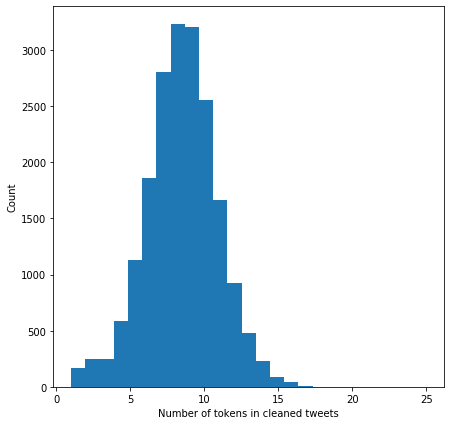

In [4]:
lenghts =  [len(x) for x in train_df['cleanedText'].str.split()]
percentile = np.percentile(lenghts,95)
print(percentile)

# Plot histogram of tweets lenght distribution in order to define the max_len parameter for the model
plt.figure(figsize=(7, 7))
plt.hist(lenghts, bins=25)
plt.xlabel('Number of tokens in cleaned tweets')
plt.ylabel('Count')
plt.show()

# Vocabulary and Feature Extraction

In [5]:
max_seq_len = 20

#preparing a tokenizer for segments on training data 
x_tokenizer = Tokenizer(oov_token = 'UNK')
x_tokenizer.fit_on_texts(train_df["cleanedText"].values)

#filter x_tokenizer by deleting items based on word counts
low_count_words = [w for w,c in x_tokenizer.word_counts.items() if c < 3]
for w in low_count_words:
    del x_tokenizer.word_index[w]
    del x_tokenizer.word_docs[w]
    del x_tokenizer.word_counts[w]    

#Apply tokenizer to the sets
X_tr = x_tokenizer.texts_to_sequences(train_df["cleanedText"].values) 

#Set token for padding sequences
x_tokenizer.word_index['PAD'] = 0
x_tokenizer.index_word[0] = 'PAD'

print(len(x_tokenizer.word_index))
X_train = pad_sequences(maxlen=max_seq_len, sequences=X_tr, padding='post', truncating = 'post', value=x_tokenizer.word_index['PAD'])

8376


## Compute Class Weights

In [6]:
##Calculate class_weights to attenuate the unbalanced classification problem 
y_train = train_df.truthClass.values
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = ['no-clickbait', 'clickbait'],
                                        y = y_train                                                   
                                    )

class_weights = dict(zip([0,1], class_weights))
print(class_weights)

{0: 0.6593648429035753, 1: 2.0687274272360314}


# CNN model

In [7]:
embedding_dim = 300
input_dim = 20
    
def CNN_model(filters, kernel_size, dense_units):

    model = Sequential()
    model.add(Embedding(input_dim=len(x_tokenizer.word_index), output_dim=embedding_dim,input_length=input_dim, trainable = True))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    return model

### Training

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           2512800   
_________________________________________________________________
conv1d (Conv1D)              (None, 18, 1024)          922624    
_________________________________________________________________
global_max_pooling1d (Global (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,566,753
Trainable params: 3,566,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
122/122 [==============================] - 5s 38ms/step - loss: 0.5475 - accuracy: 0.7487 - val_loss

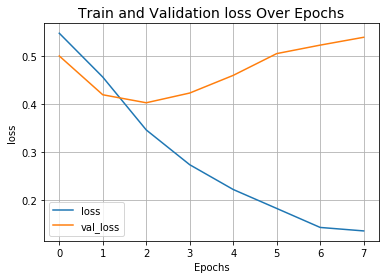

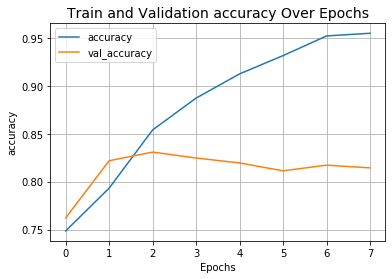

In [8]:
##Build and train CNN model
y_train = train_df.label.values
model = CNN_model(filters=1024, kernel_size=3, dense_units=128)
model, history, runtime = train_model(model, X_train, y_train, learning_rate=0.0001, epochs=100, batch_size=128)

### Load Test Dataset

In [9]:
# Load test dataset
filename = '../data/webis_test.csv'
test_df = read_data(filename)

In [10]:
max_seq_len = 20
#Apply same preprocessing and tokenizer to test dataset tweets
test_df['cleanedText'] = test_df.postText.apply(lambda x: deep_clean_tweet(x))
test_df  = test_df.loc[test_df.cleanedText != '']

X_te = x_tokenizer.texts_to_sequences(test_df["cleanedText"].values) 
X_test = pad_sequences(maxlen=max_seq_len, sequences=X_te, padding='post', truncating = 'post', value=x_tokenizer.word_index['PAD'])

### Evaluation

In [11]:
##Evaluate CNN model
y_test = test_df.label.values
predictions = evaluate_model(model, X_test, y_test, threshold = 0.5)
##Get Classification report
classes = ['no-clickbait', 'clickbait']
print("\nClassification report : \n", classification_report(test_df.label.values, predictions, zero_division = 0, target_names=classes))

591/591 [==============================] - 2s 4ms/step - loss: 0.3878 - accuracy: 0.8338
Test loss: 0.3878333866596222
Test accuracy 0.8338183164596558

Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.86      0.93      0.90     14454
   clickbait       0.70      0.52      0.60      4447

    accuracy                           0.83     18901
   macro avg       0.78      0.73      0.75     18901
weighted avg       0.82      0.83      0.82     18901



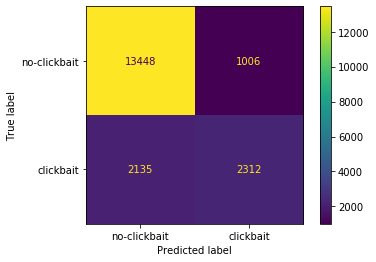

In [12]:
##Get Confusion Matrix
cm = confusion_matrix(test_df.label.values, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

In [13]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.833818316491191
F1 Score:  0.595492594977463
Precision Score:  0.6968053044002411
Recall Score:  0.5199010568922869


In [14]:
path = '../trained_models/CNNs'
if not os.path.isdir(path):
    os.mkdir(path)

model.save(path + '/01_cnn_model.h5')
with open(path + '/01_cnn_vocab.json', "wb") as f:
    f.write(json.dumps(x_tokenizer.word_index).encode("utf-8"))

In [15]:
#Save metrics and runtime
name = 'cnn_baseline'
write_metrics(name, accuracy, f1, precision, recall, runtime, results_path = '../trained_models', results_filename = 'results.csv')  

File does not exist. Creating results file.


### Training with ClassWeights

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 300)           2512800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 1024)          922624    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 3,566,753
Trainable params: 3,566,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
122/122 [==============================] - 2s 16ms/step - loss: 0.6509 - accuracy: 0.7429 - val_lo

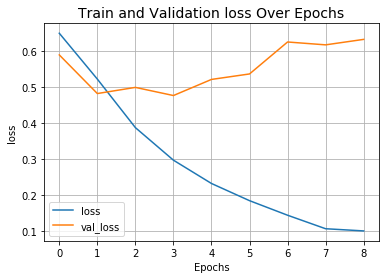

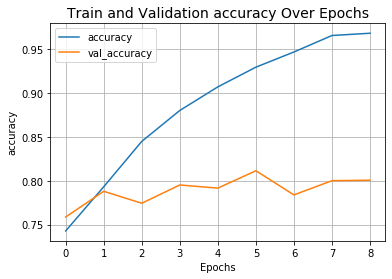

In [16]:
##Build and train CNN model
y_train = train_df.label.values
model = CNN_model(filters=1024, kernel_size=3, dense_units=128)
model, history = train_model(model, X_train, y_train, learning_rate=0.0001, epochs=100, batch_size=128, class_weights = class_weights)

### Evaluation

In [17]:
##Evaluate CNN model
predictions = evaluate_model(model, X_test, y_test, threshold = 0.5)
##Get Classification report
classes = ['no-clickbait', 'clickbait']
print("\nClassification report : \n", classification_report(y_test, predictions, zero_division = 0, target_names=classes))

591/591 [==============================] - 2s 3ms/step - loss: 0.4559 - accuracy: 0.8059
Test loss: 0.4559089243412018
Test accuracy 0.8059362173080444

Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.90      0.84      0.87     14454
   clickbait       0.57      0.69      0.63      4447

    accuracy                           0.81     18901
   macro avg       0.74      0.77      0.75     18901
weighted avg       0.82      0.81      0.81     18901



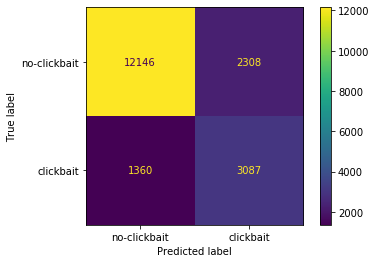

In [18]:
##Get Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

In [19]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.8059361938521772
F1 Score:  0.627311522048364
Precision Score:  0.5721964782205746
Recall Score:  0.69417584888689


In [20]:
path = '../trained_models/CNNs'
if not os.path.isdir(path):
    os.mkdir(path)

model.save(path + '/01_cnn_classWeights_model.h5')
with open(path + '/01_cnn_classWeights_vocab.json', "wb") as f:
    f.write(json.dumps(x_tokenizer.word_index).encode("utf-8"))

In [21]:
#Save metrics and runtime
name = 'cnn_classWeights'
write_metrics(name, accuracy, f1, precision, recall, results_path = '../trained_models', results_filename = 'results.csv')  

# LSTM model

### Training

In [22]:
def LSTM_model(lstm_units,dropout_rate):
    
    model = Sequential()
    inputs = Input(shape=(input_dim), name='inputs')
    emb = Embedding(input_dim=len(x_tokenizer.word_index), output_dim=embedding_dim,input_length=input_dim, trainable = True)(inputs)
    lstm = LSTM(lstm_units, return_sequences=True)(emb)
    gmp = GlobalMaxPooling1D()(lstm)
    drop = Dropout(dropout_rate)(gmp)
    output = Dense(1, activation='sigmoid')(drop)
    model = Model(inputs, output, name='lstm_model')
    model.summary()

    return model

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 20)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 20, 300)           2512800   
_________________________________________________________________
lstm (LSTM)                  (None, 20, 512)           1665024   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 4,178,337
Trainable params: 4,178,337
Non-trainable params: 0
______________________________________________

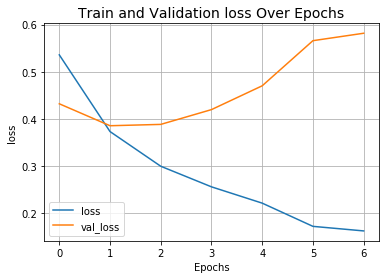

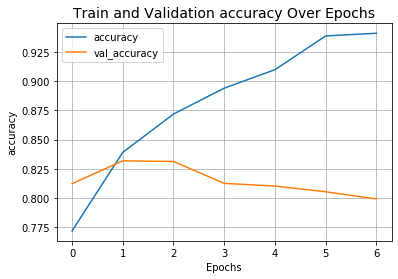

In [23]:
##Build and train LSTM model
model = LSTM_model(lstm_units=512,dropout_rate=0.2)
model, history, runtime = train_model(model,X_train, y_train, learning_rate=0.0001, epochs=100, batch_size=128)

### Evaluation

In [24]:
predictions = evaluate_model(model, X_test, y_test, threshold = 0.5)
##Get Classification report
classes = ['no-clickbait', 'clickbait']
print("\nClassification report : \n", classification_report(y_test, predictions, zero_division = 0, target_names=classes))

591/591 [==============================] - 2s 3ms/step - loss: 0.3686 - accuracy: 0.8399
Test loss: 0.36860111355781555
Test accuracy 0.8399026393890381

Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.89      0.90      0.90     14454
   clickbait       0.66      0.65      0.66      4447

    accuracy                           0.84     18901
   macro avg       0.78      0.77      0.78     18901
weighted avg       0.84      0.84      0.84     18901



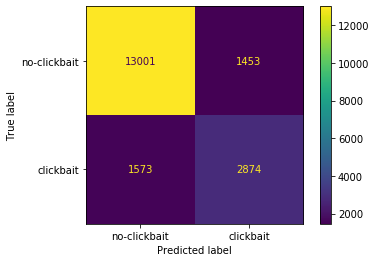

In [25]:
##Get Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

In [26]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.8399026506534046
F1 Score:  0.6551173922954183
Precision Score:  0.6642015253062168
Recall Score:  0.6462783899257927


In [27]:
path = '../trained_models/LSTMs'
if not os.path.isdir(path):
    os.mkdir(path)

model.save(path + '/01_lstm_model.h5')
with open(path + '/01_lstm_vocab.json', "wb") as f:
    f.write(json.dumps(x_tokenizer.word_index).encode("utf-8"))

In [28]:
#Save metrics and runtime
name = 'lstm_baseline'
write_metrics(name, accuracy, f1, precision, recall, runtime, results_path = '../trained_models', results_filename = 'results.csv')  

### Training with ClassWeights

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 20)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 20, 300)           2512800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 512)           1665024   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 4,178,337
Trainable params: 4,178,337
Non-trainable params: 0
______________________________________________

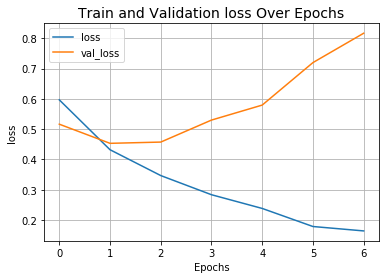

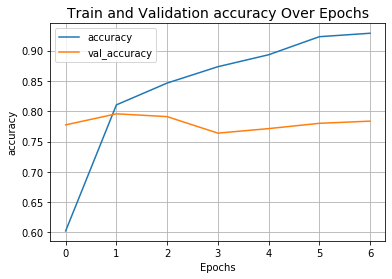

In [29]:
##Build and train LSTM model
model = LSTM_model(lstm_units=512,dropout_rate=0.2)
model, history, runtime = train_model(model, X_train, y_train, learning_rate=0.0001, epochs=100, batch_size=128, class_weights = class_weights)

### Evaluation

In [30]:
##Evaluate LSTM model
predictions = evaluate_model(model, X_test, y_test, threshold = 0.5)
##Get Classification report
classes = ['no-clickbait', 'clickbait']
print("\nClassification report : \n", classification_report(y_test, predictions, zero_division = 0, target_names=classes))

591/591 [==============================] - 2s 3ms/step - loss: 0.4413 - accuracy: 0.8026
Test loss: 0.441292941570282
Test accuracy 0.8025501370429993

Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.92      0.81      0.86     14454
   clickbait       0.56      0.77      0.65      4447

    accuracy                           0.80     18901
   macro avg       0.74      0.79      0.76     18901
weighted avg       0.83      0.80      0.81     18901



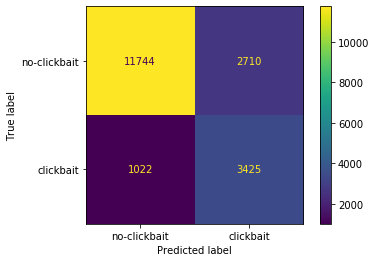

In [31]:
##Get Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

In [32]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.8025501296227713
F1 Score:  0.6473256473256472
Precision Score:  0.5582722086389568
Recall Score:  0.7701821452664718


In [33]:
path = '../trained_models/LSTMs'
if not os.path.isdir(path):
    os.mkdir(path)

model.save(path + '/01_lstm_classWeights_model.h5')
with open(path + '/01_lstm_classWeights_vocab.json', "wb") as f:
    f.write(json.dumps(x_tokenizer.word_index).encode("utf-8"))

In [34]:
#Save metrics and runtime
name = 'lstm_classWeights'
write_metrics(name, accuracy, f1, precision, recall, runtime, results_path = '../trained_models', results_filename = 'results.csv')  

# GRU model

### Training

In [35]:
def GRU_model(gru_units, dropout_rate):
    
    model = Sequential()
    inputs = Input(shape=(input_dim), name='inputs')
    emb = Embedding(input_dim=len(x_tokenizer.word_index), output_dim=embedding_dim,input_length=input_dim, trainable = True)(inputs)
    lstm = GRU(gru_units, return_sequences=True)(emb)
    gmp = GlobalMaxPooling1D()(lstm)
    drop = Dropout(dropout_rate)(gmp)
    output = Dense(1, activation='sigmoid')(drop)
    model = Model(inputs, output, name='lstm_model')
    model.summary()

    return model

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 20)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 20, 300)           2512800   
_________________________________________________________________
gru (GRU)                    (None, 20, 512)           1250304   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 3,763,617
Trainable params: 3,763,617
Non-trainable params: 0
______________________________________________

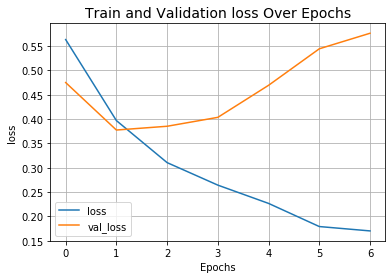

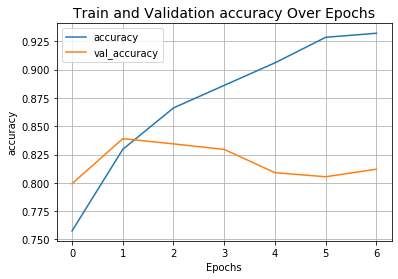

In [36]:
#Build and train GRU model
model = GRU_model(gru_units=512, dropout_rate=0.2)
model, history, runtime = train_model(model,X_train, y_train, learning_rate=0.0001, epochs=100, batch_size=128)

### Evaluation

In [37]:
#Evaluate GRU model
predictions = evaluate_model(model, X_test, y_test, threshold = 0.5)
##Get Classification report
classes = ['no-clickbait', 'clickbait']
print("\nClassification report : \n", classification_report(y_test, predictions, zero_division = 0, target_names=classes))

591/591 [==============================] - 2s 3ms/step - loss: 0.3642 - accuracy: 0.8452
Test loss: 0.3641948103904724
Test accuracy 0.8452462553977966

Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.87      0.93      0.90     14454
   clickbait       0.72      0.56      0.63      4447

    accuracy                           0.85     18901
   macro avg       0.80      0.75      0.77     18901
weighted avg       0.84      0.85      0.84     18901



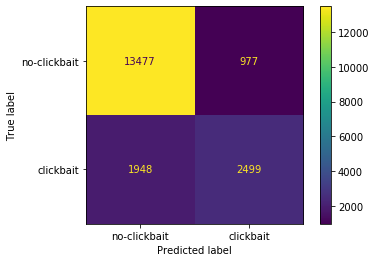

In [38]:
##Get Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

In [39]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.8452462832654357
F1 Score:  0.6308216584627035
Precision Score:  0.7189298043728424
Recall Score:  0.5619518776703396


In [40]:
path = '../trained_models/GRUs'
if not os.path.isdir(path):
    os.mkdir(path)

model.save(path + '/01_gru_model.h5')
with open(path + '/01_gru_vocab.json', "wb") as f:
    f.write(json.dumps(x_tokenizer.word_index).encode("utf-8"))

In [41]:
#Save metrics and runtime
name = 'gru_baseline'
write_metrics(name, accuracy, f1, precision, recall, runtime, results_path = '../trained_models', results_filename = 'results.csv')  

### Training with ClassWeights

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 20)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 20, 300)           2512800   
_________________________________________________________________
gru_1 (GRU)                  (None, 20, 512)           1250304   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 3,763,617
Trainable params: 3,763,617
Non-trainable params: 0
______________________________________________

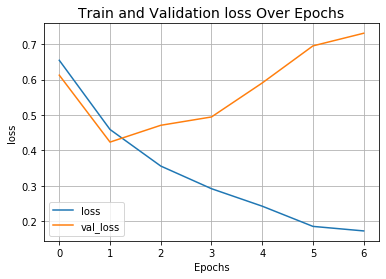

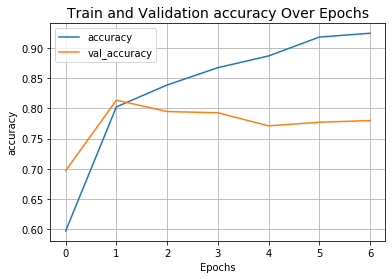

In [42]:
##Build and train GRU model
model = GRU_model(gru_units=512, dropout_rate=0.2)
model, history, runtime = train_model(model, X_train, y_train, learning_rate=0.0001, epochs=100, batch_size=128, class_weights = class_weights)

### Evaluation

In [43]:
##Evaluate GRU model
predictions = evaluate_model(model, X_test, y_test, threshold = 0.5)
##Get Classification report
classes = ['no-clickbait', 'clickbait']
print("\nClassification report : \n", classification_report(y_test, predictions, zero_division = 0, target_names=classes))

591/591 [==============================] - 2s 3ms/step - loss: 0.4068 - accuracy: 0.8227
Test loss: 0.4067640006542206
Test accuracy 0.8227077722549438

Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.91      0.85      0.88     14454
   clickbait       0.60      0.74      0.66      4447

    accuracy                           0.82     18901
   macro avg       0.76      0.79      0.77     18901
weighted avg       0.84      0.82      0.83     18901



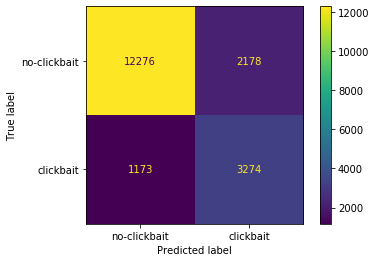

In [44]:
##Get Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

In [45]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.822707793238453
F1 Score:  0.6614809576724923
Precision Score:  0.6005135730007337
Recall Score:  0.7362266696649427


In [46]:
path = '../trained_models/GRUs'
if not os.path.isdir(path):
    os.mkdir(path)

model.save(path + '/01_gru_classWeights_model.h5')
with open(path + '/01_gru_classWeights_vocab.json', "wb") as f:
    f.write(json.dumps(x_tokenizer.word_index).encode("utf-8"))

In [47]:
#Save metrics and runtime
name = 'gru_classWeights'
write_metrics(name, accuracy, f1, precision, recall, runtime, results_path = '../trained_models', results_filename = 'results.csv')  